# Tutorial 4: Integration of simulated spatial multi-omics data

In this tutorial, we performed experiments in simulated spatial multi-omics data to quantitatively validate the performance of the model. We employed the non-negative spatial factorization (NSF) method proposed by Townes et al. to simulate spatial multi-omics data. We used a combination of simulated spatial transcriptome and spatial proteome data as an example.

The SpaMI model is based on the pytorch framework and can be run on GPU or CPU. This tutorial is implemented on an NVIDIA GeForce RTX 3090.

## Loading package

In [1]:
import h5py
import torch
import sklearn
import episcanpy
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from utils import fix_seed

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 2024
fix_seed(2024)

## Loading data

Since the data storage format is h5ad, we use the scanpy library to load it.

In [3]:
rna_file = '/home/gaocongqiang/SpaMI/data/Simulation/adata_RNA.h5ad'
protein_file = '/home/gaocongqiang/SpaMI/data/Simulation/adata_ADT.h5ad'

adata_omics1 = sc.read_h5ad(rna_file)
adata_omics2 = sc.read_h5ad(protein_file)

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

## Preprocessing data

For preprocessing, we utilize the scanpy package for the spatial transcriptome data, filtering out genes expressed in fewer than 10 cells, followed by logarithmic transformation and normalization. Dimensionality reduction is then performed via PCA, reducing the data to 100 dimensions. For the spatial proteome, we apply centered log-ratio normalization (CLR) to process the protein count matrix. 

In [4]:
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix

if isinstance(adata_omics1.X, csc_matrix) or isinstance(adata_omics1.X, csr_matrix):
    feat_omics1 = adata_omics1.X.toarray()[:, ]
else:
    feat_omics1 = adata_omics1.X[:, ]
pca = sklearn.decomposition.PCA(n_components=100)
feat_omics1 = pca.fit_transform(feat_omics1)

In [5]:
import scipy

def seurat_clr(x):
    s = np.sum(np.log1p(x[x > 0]))
    exp = np.exp(s / len(x))
    return np.log1p(x / exp)

# apply to dense or sparse matrix, along axis. returns dense matrix
adata_omics2.X = np.apply_along_axis(seurat_clr, 1, (adata_omics2.X.A if scipy.sparse.issparse(adata_omics2.X) else np.array(adata_omics2.X)))
feat_omics2 = adata_omics2.X

Next, we need to create the spatial neighbor graph and obtain the labels required for subsequent contrastive learning. When creating the spatial graph, the number of neighbors per spot is set to 3 for this dataset. Finally, we get the preprocessed data required for model training.

In [6]:
from preprocess import construct_adj, add_contrastive_label

adj_omics1, graph_neigh_omics1 = construct_adj(adata_omics1, n_neighbors=3)
label_CSL_omics1 = add_contrastive_label(adata_omics1)

omics1_data = {
        'feat': feat_omics1,
        'adj': adj_omics1,
        'graph_neigh': graph_neigh_omics1,
        'label_CSL': label_CSL_omics1,
    }

In [7]:
adj_omics2, graph_neigh_omics2 = construct_adj(adata_omics2, n_neighbors=3)
label_CSL_omics2 = add_contrastive_label(adata_omics2)
omics2_data = {
        'feat': feat_omics2,
        'adj': adj_omics2,
        'graph_neigh': graph_neigh_omics2,
        'label_CSL': label_CSL_omics2,
    }

## Training the model

The SpaMI model further refines the latent representation of each modality's spot by associating it with its local context through a contrastive learning strategy. Finally, the latent representations of each modality are adaptively integrated through an attention aggregation mechanism to obtain a joint representation.

After the model training is completed, the model can output the latent joint embedding of spots. The joint representation can be used for a variety of downstream analyses such as clustering, visualization, and identification of differentially expressed features.

In [8]:
from main import train

train(omics1_data, omics2_data, 'Simulation', out_dim=64)

100%|██████████| 1000/1000 [00:32<00:00, 30.95it/s]


Model training completed!


## Clustering and Visualization

In [9]:
result = np.load('../result/Simulation/combine_emb.npy')

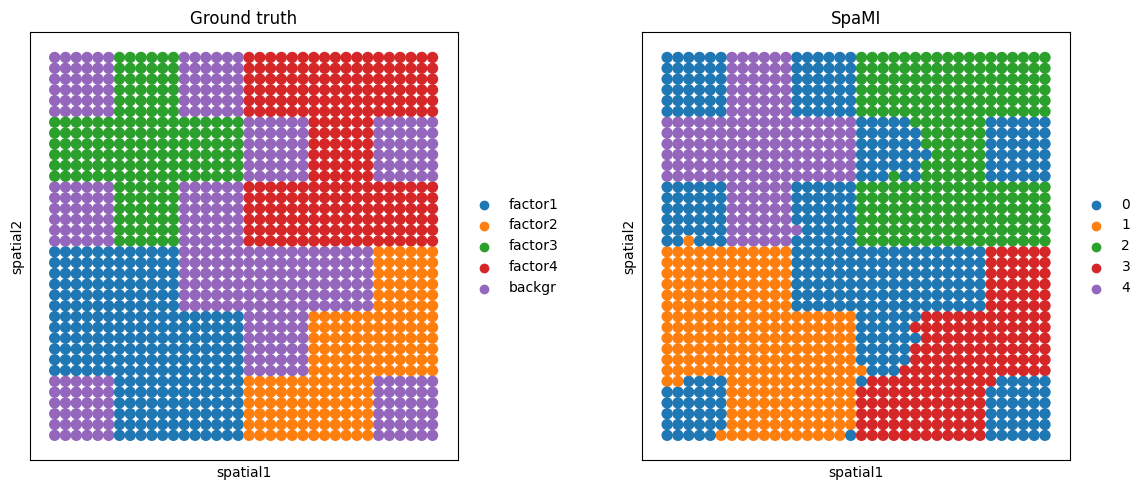

In [10]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))

adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['annotation'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['annotation'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['annotation']  = pd.Categorical(adata_omics1.obs['annotation'], 
                      categories=list_,
                      ordered=True)


adata = AnnData(result)
adata.obsm['spatial'] = adata_omics1.obsm['spatial']

sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.leiden(adata, resolution=0.4)

sc.pl.spatial(adata_omics1, color='annotation', spot_size=0.12, ax=ax_list[0], show=False, title='Ground truth')
sc.pl.spatial(adata, color='leiden', spot_size=0.12, ax=ax_list[1], show=False, title='SpaMI')



plt.tight_layout(w_pad=1)
plt.show()

## Quantitative analysis

In [11]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score

ground_truth = adata_omics1.obs['ground_truth']
cluster_labels = adata.obs['leiden']

ari = adjusted_rand_score(ground_truth, cluster_labels)
print("ARI:", ari)

ami = adjusted_mutual_info_score(ground_truth, cluster_labels)
print("AMI:", ami)

nmi = normalized_mutual_info_score(ground_truth, cluster_labels)
print("NMI:", nmi)

homo = homogeneity_score(ground_truth, cluster_labels)
print("Homo:", homo)

ARI: 0.9626734878785889
AMI: 0.9531810306857929
NMI: 0.9533680373143608
Homo: 0.9551939051899123
